### Estadística
Esta es la continuación del notebook pasado, qui se encuentran los gráficos estadísticos que realizamos y colocamos
dentro del documento.



In [79]:
#Seguimos importando lobrerias 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import numpy as np
import seaborn as sea
import pandas as pd

In [8]:
ds=xr.open_dataset('4901476_prof.nc')
# ds=xr.open_dataset('4901477_prof.nc')
# ds=xr.open_dataset('4903276_prof.nc')
ds

<xarray.Dataset>
Dimensions:                       (N_PROF: 283, N_PARAM: 3, N_LEVELS: 1010,
                                   N_CALIB: 1)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/52)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COMMENT      (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_DATE         (N_PROF, N_CALIB, N_PARAM) object ...
Attributes:
    title:                  Argo float aggregated multi-cycle profile
    institution:            US GDAC
    source:                 Argo float
    history:                2022-10-05T21:00:05Z
    references:             http://www.argodatamgt.org/Documentation
    comment:                free text
    user_manual_version:    3.2
    Conventions:            Argo-3.2 CF-1.6
    featureType:            trajectoryProfile
    comment_dmqc_operator:  PRIMARY | https://orcid.org/0000-0001-6630-1293 |...

In [28]:
''' Obtuve las fechas de los respectivos perfiles'''
# import pandas as pd
# import numpy as np 
# Fechas=pd.DataFrame(np.array(ds.JULD[42:55].dt.strftime('%y/%m/%d').data) , 
#              np.array(ds.JULD[23:36].dt.strftime('%y/%m/%d').data))
# Fechas

' Obtuve las fechas de los respectivos perfiles'

#### Energia Potencial de Boyancia

In [17]:
################################# Diferencias Finitas
def Dif (a,x):
    ai =a[:-2]
    bi =a[2:]
    h = bi-ai
    Dcen= (x[2:]-x[:-2])/(h)
    return (Dcen)

################################ Regla del Trapecio
def integratrapecio_fi(xi,fi):
    n = len(xi)
    trapecios = np.zeros_like(xi)
    dx = xi[1:]-xi[:-1]
    trapecios = dx*(fi[1:]+fi[:-1])/2
    return(trapecios)
#################################  Arreglo de zeros
PP= np.zeros(shape=(1006,250))
Depth=np.zeros(shape=(1010,250))
DPot=np.zeros(shape=(1010,250))
BV=np.zeros(shape=(1009,250))
for i in range(250):     ### Ciclo
    lon = ds.LONGITUDE[i]
    lat = ds.LATITUDE[i]
    T = ds.TEMP_ADJUSTED[i]   # in situ T
    P = ds.PRES_ADJUSTED[i]   # presión
    Sp = ds.PSAL_ADJUSTED[i]  #salinidad práctica
    SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
    Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
    CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
    ########################
    Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000
    N2,p_mid=gsw.Nsquared(SA,CT,P)
    z = -1*gsw.z_from_p(P,lat) # Depht real  a través de la Presion y Lat del perfil
    d = np.array(Dens)
    ###########3###########
    DC = Dif(z,d)
   #############################3
    at = integratrapecio_fi(z[1:-1],DC) # arreglo con las áreas de los trapecios
    ic= np.cumsum(at) # suma cumulativa de áreas de los trapecios
    ############################
    f1 = ic
    a_t = integratrapecio_fi(z[2:-1],f1) # arreglo con las áreas de los trapecios
    i_c = np.cumsum(a_t) # suma cumulativa de áreas de los trapecios #EPB
    #######################33#
    i_c=i_c
    PP[:,i]=i_c
    Depth[:,i]=z
    DPot[:,i]=Dens
    BV[:,i]=N2

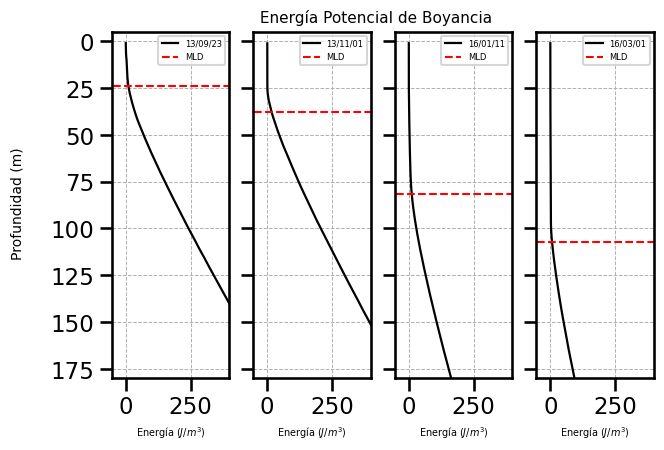

In [18]:
#Graficamos
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(1,4,figsize=(7,4.5),sharey=True)
    fig.suptitle(' Energía Potencial de Boyancia', fontsize =11,color ='k',y=0.93) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    # fig.supxlabel(r'Energía ($J/m^3$)',fontsize=10,y=-0.03)
    fig.supylabel('Profundidad (m)',fontsize=10,x=-0.02)
    # fig.subplots_adjust(hspace=0)

    axs[0].plot(PP[:,10],Depth[0:-4,10],'k',linewidth = 1.6,label=ds.JULD[10].dt.strftime('%y/%m/%d').values)
    axs[0].plot([-50,400],[Depth[16,10],Depth[16,10]],'r--',label='MLD',linewidth=1.5)
    axs[0].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[0].legend(fontsize=6)
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    axs[0].set_ylim(180,-5)
    axs[0].set_xlim(-55,400)
    
    axs[1].plot(PP[:,15],Depth[0:-4,15],'k',linewidth = 1.6,label=ds.JULD[20].dt.strftime('%y/%m/%d').values)
    axs[1].plot([-50,400],[Depth[23,15],Depth[23,15]],'r--',label='MLD',linewidth=1.5)
    axs[1].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[1].legend(fontsize=6)
    axs[1].invert_yaxis()
    axs[1].grid(linestyle='--',linewidth=0.7)
    axs[1].set_ylim(180,-5)
    axs[1].set_xlim(-55,400)
    
    axs[2].plot(PP[:,100],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[100].dt.strftime('%y/%m/%d').values)
    axs[2].plot([-50,400],[z[45],z[45]],'r--',label='MLD',linewidth=1.5)
    axs[2].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[2].legend(fontsize=6)
    axs[2].invert_yaxis()
    axs[2].set_ylim(180,-5)
    axs[2].set_xlim(-55,400)
    axs[2].grid(linestyle='--',linewidth=0.7)
    
    axs[3].plot(PP[:,105],z[0:-4],'k',linewidth = 1.6,label=ds.JULD[105].dt.strftime('%y/%m/%d').values)
    axs[3].plot([-50,400],[z[58],z[58]],'r--',label='MLD',linewidth=1.5)
    axs[3].set_xlabel(r'Energía ($J/m^3$)',fontsize=7,y=-0.03)
    axs[3].legend(fontsize=6)
    axs[3].invert_yaxis()
    axs[3].set_ylim(180,-5)
    axs[3].set_xlim(-55,400)
    axs[3].grid(linestyle='--',linewidth=0.7)

In [19]:
ds.JULD[200].data

numpy.datetime64('2018-09-12T12:52:05.001362944')

In [20]:
PP[10:20,75] 

array([0.11276613, 0.14433793, 0.18083607, 0.22180041, 0.26524051,
       0.31041528, 0.35508557, 0.40062923, 0.44960577, 0.49537475])

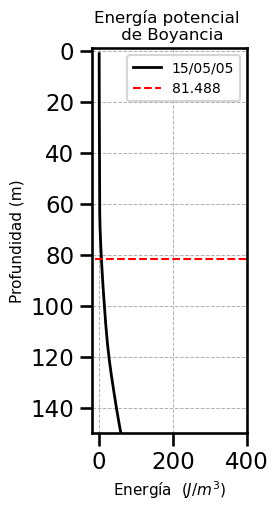

In [27]:
n= 45
nprof=75
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(2,5))
    ax.plot(PP[:,nprof],Depth[0:-4,nprof],'k',linewidth = 2,label=ds.JULD[nprof].dt.strftime('%y/%m/%d').values)
    ax.set_ylabel( 'Profundidad (m)',fontsize=11)
    ax.set_xlabel(r'Energía  ($J/m^3$)',fontsize=11)
    ax.set_title('Energía potencial \n de Boyancia', fontsize =12,color = 'black')
    
    ax.plot([-10,400],[Depth[n,nprof],Depth[n,nprof]],'r--',label=format(Depth[n,nprof],'.3f'),linewidth=1.5)
    # ax.plot([-10,400],[Depth[14,nprof],Depth[14,nprof]],'b--',labe=format(Depth[14,nprof],'.2f'),linewidth=1.5)
    # ax.plot([-10,400],[z[11],z[11]],'r--',label=format(z[11],'.2f'),linewidth=1.5)
    # ax.legend(fontsize=8)
    ax.set_ylim(-1,150)
    ax.set_xlim(-20,400)
    ax.invert_yaxis()
    ax.grid(linestyle='--',linewidth=0.7)
    ax.legend(fontsize=10)

In [29]:
PP.shape, Depth.shape , DPot.shape

((1006, 250), (1010, 250), (1010, 250))

(-5.0, 80.0)

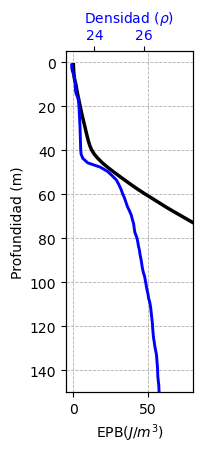

In [32]:
num=80
fig, ax1 = plt.subplots(figsize=(2,4))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'EPB($J/m^3$)', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(PP[:,num],Depth[0:-4,num] ,'k', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='k')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel(r'Densidad ($\rho$)',color='blue',fontsize=10)  # we already handled the x-label with ax1
ax2.plot(DPot[:,num],Depth[:,num],'blue',linewidth = 2.1)
ax2.tick_params(axis='x', labelcolor='b',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

(-5.0, 80.0)

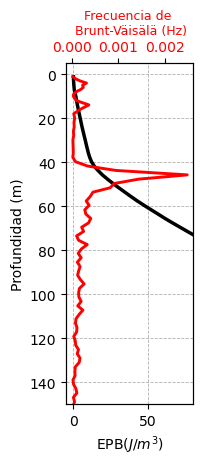

In [34]:
num=80
fig, ax1 = plt.subplots(figsize=(2,4))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'EPB($J/m^3$)', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(PP[:,num],Depth[0:-4,num] ,'k', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='k')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel('Frecuencia de \n Brunt-Väisälä (Hz)',color='red',fontsize=9)  # we already handled the x-label with ax1
ax2.plot(BV[:,num],Depth[0:-1,num],'red',linewidth = 2.1)
ax2.tick_params(axis='x', labelcolor='r',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

(150.0, -5.0)

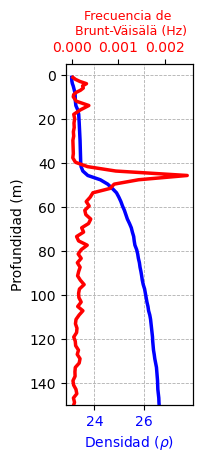

In [35]:
num=80
fig, ax1 = plt.subplots(figsize=(2,4))
fig.tight_layout()  
# fig.suptitle(' Estabilidad estatica vs Densidad ', fontsize=14)

ax1.set_xlabel(r'Densidad ($\rho$)',color='blue', fontsize=10)
ax1.set_ylabel('Profundidad (m)')#,fontsize=10)
ax1.plot(DPot[:,num],Depth[:,num] ,'b', linewidth = 2.5)
ax1.tick_params(axis='x' ,labelcolor='b')
# ax1.autoscale(True)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis\

ax2.set_xlabel('Frecuencia de \n Brunt-Väisälä (Hz)',color='red',fontsize=9)  # we already handled the x-label with ax1
ax2.plot(BV[:,num],Depth[0:-1,num],'red',linewidth = 2.5)
ax2.tick_params(axis='x', labelcolor='r',)
ax2.invert_yaxis()

ax1.grid(linestyle='--', linewidth=0.6)
ax1.set_ylim(150,-5)
# ax1.set_xlim(-5,80)

# ax1.set_xlim(23.8,26)

In [ ]:
# ds

#### Obteniendo los perfiles de densidad

In [40]:
DP= np.zeros(shape=(1010,250))
for i in range(250):     ### Ciclo
    lon = ds.LONGITUDE[i]
    lat = ds.LATITUDE[i]
    T = ds.TEMP_ADJUSTED[i]   # in situ T
    P = ds.PRES_ADJUSTED[i]   # presión
    Sp = ds.PSAL_ADJUSTED[i]  #salinidad práctica
    SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
    Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
    CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
    ########################
    Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000
    DP[:,i]=Dens

In [43]:
PP.shape

(1006, 250)

In [45]:
time=10
lon = ds.LONGITUDE[time]
lat = ds.LATITUDE[time]
T = ds.TEMP_ADJUSTED[time]   # in situ T
P = ds.PRES_ADJUSTED[time]   # presión
Sp = ds.PSAL_ADJUSTED[time]  #salinidad práctica
SA = gsw.conversions.SA_from_SP(Sp, P, lon, lat) # SA a partir de salinidad potencial
Tp = gsw.conversions.pt0_from_t(SA, T, P) # temperatura potencial con p_ref=0
CT = gsw.conversions.CT_from_t(SA, T, P) # temperatura conservativa 
########################
Dens = gsw.density.sigma0(SA,CT) # densidad potencial referencia 0dbar - 1000

N2,p_mid=gsw.Nsquared(SA,CT,P)

In [55]:
# ds.JULD_LOCATION[60:80].data

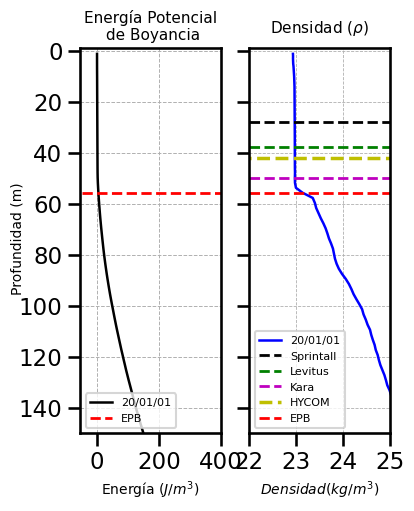

In [84]:
'''Comparativa de la EPB y las metodologias para el calculo de la MLD'''
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(1,2,figsize=(4,5),sharey=True)
    # fig.suptitle('Comparativa entre perfiles ', fontsize=14) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    fig.supylabel('Profundidad (m)',fontsize=10,x=-0.05)
    # fig.subplots_adjust(hspace=0)

    axs[0].plot(PP[:,90],Depth[0:-4,90],'k',linewidth = 1.8,label=ds.JULD[i].dt.strftime('%y/%m/%d').values)
    axs[0].set_xlabel(r'Energía ($J/m^3$)',fontsize=10)
    axs[0].set_title('Energía Potencial\n de Boyancia', fontsize =11,color = 'black')
    axs[0].plot([-50,400],[Depth[32,90],Depth[32,90]],'r--',label='EPB',linewidth=2)
    axs[0].legend(fontsize=8, loc='lower left')
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    # axs[0].set_ylim(90,-5)
    axs[0].set_xlim(-55,400)

    axs[1].plot(DP[:,90],Depth[:,90],'blue',linewidth = 1.8,label=ds.JULD[i].dt.strftime('%y/%m/%d').values)
    axs[1].set_xlabel(r'$Densidad(kg/m^3)$',fontsize=10)
    axs[1].set_title(r'Densidad $(\rho)$',fontsize =11,y=1.02)
    axs[1].plot([12,27],[Depth[18,90],Depth[18,90]],'k--', label='Sprintall',linewidth=2)
    axs[1].plot([12,27],[Depth[23,90],Depth[23,90]],'g--', label='Levitus',linewidth=2)
    axs[1].plot([12,27],[Depth[29,90],Depth[29,90]],'m--', label='Kara',linewidth=2)
    axs[1].plot([12,27],[Depth[25,90],Depth[25, 90]],'y--', label='HYCOM',linewidth=2.5)
    axs[1].plot([-50,400],[Depth[32,90],Depth[32,90]],'r--',label='EPB',linewidth=2)
    axs[1].legend( loc = 'lower left' , fontsize=8)
    axs[1].set_ylim(150,-1)
    axs[1].set_xlim(22,25)
    axs[1].grid(linestyle='--',linewidth=0.6)

#### Graficas por temporada 

In [85]:
# data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')
data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD_V.csv')
type(data), data

(pandas.core.frame.DataFrame,
             MT  LEVITUS  SPRINTALL   KARA HYCOM     PE  HYCOM_1
 0   2014-06-09    15.94      15.94  17.88  2.97  13.91   -10.93
 1   2014-06-19    21.86      13.95  23.84  9.26  19.87   -10.61
 2   2014-06-29     9.98       9.98  17.84  5.70   9.93    -4.23
 3   2014-07-09    11.96       9.98  11.80  0.94   8.94    -8.00
 4   2014-07-19    11.96      15.94  11.80  4.06   9.93    -5.88
 ..         ...      ...        ...    ...   ...    ...      ...
 73  2021-09-10    29.77      15.90  49.68   Nan  45.70      NaN
 74  2021-09-15    15.86      17.89  69.51   Nan  57.62      NaN
 75  2021-09-20    49.64      15.94  69.58   Nan  69.58      NaN
 76  2021-09-25    47.73      15.94  55.64   Nan  49.64      NaN
 77  2021-09-30     7.95      15.90  43.72   Nan   7.95      NaN
 
 [78 rows x 7 columns])

In [86]:
data['MT'] = pd.to_datetime(data['MT'])
print (type(data.MT[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [87]:
datos = data.sort_values(by='MT')
datos

,MT,LEVITUS,SPRINTALL,KARA,HYCOM,PE,HYCOM_1
0,2014-06-09,15.94,15.94,17.88,2.97,13.91,-10.93
1,2014-06-19,21.86,13.95,23.84,9.26,19.87,-10.61
2,2014-06-29,9.98,9.98,17.84,5.70,9.93,-4.23
3,2014-07-09,11.96,9.98,11.80,0.94,8.94,-8.00
4,2014-07-19,11.96,15.94,11.80,4.06,9.93,-5.88
...,...,...,...,...,...,...,...
75,2021-09-20,49.64,15.94,69.58,Nan,69.58,NaN
51,2021-09-22,37.75,19.79,43.71,Nan,39.78,NaN
76,2021-09-25,47.73,15.94,55.64,Nan,49.64,NaN
52,2021-09-27,43.71,19.87,51.62,Nan,47.69,NaN


In [88]:
# datos['MT'][0:12], datos['MT'][12:25], datos['MT'][25:]

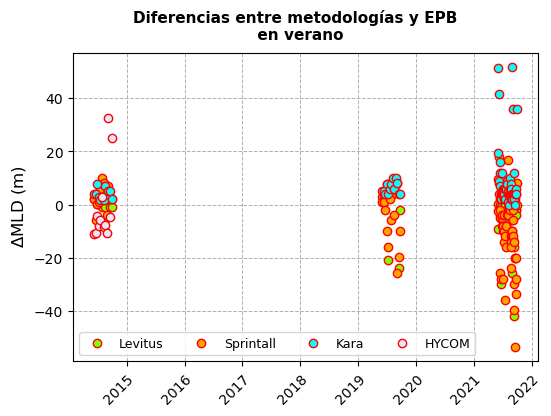

In [90]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,4))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)
    
    ax.plot(datos['MT'], datos['LEVITUS']-datos['PE'],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
    ax.plot(datos['MT'], datos['SPRINTALL']-datos['PE'],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
    ax.plot(datos['MT'], datos['KARA']-datos['PE'],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    ax.plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')

    ax.legend(ncol=4,fontsize=9, loc = 'lower left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n en verano',fontsize =11,y=0.99,fontweight ='bold')

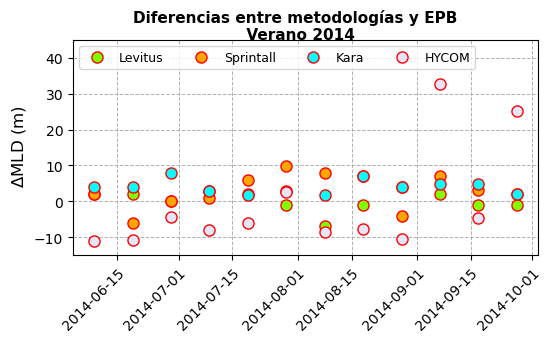

In [91]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)
    # fig.supxlabel('Tiempo ',fontsize=12)

    ax.plot(datos['MT'][0:12], datos['LEVITUS'][0:12]-datos['PE'][0:12],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][0:12], datos['SPRINTALL'][0:12]-datos['PE'][0:12],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][0:12], datos['KARA'][0:12]-datos['PE'][0:12],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-15,45)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9, loc = 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2014',fontsize =11,y=0.989,fontweight ='bold')

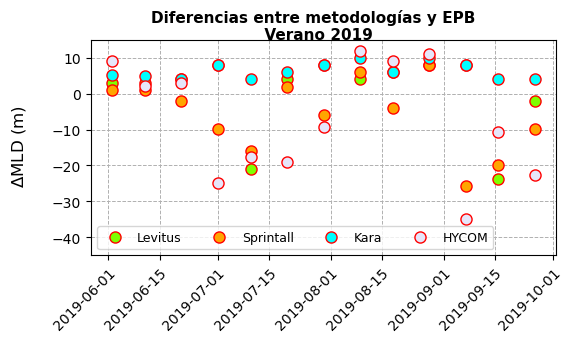

In [92]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 12,25 
    ax.plot(datos['MT'][ini:fin], datos['LEVITUS'][ini:fin]-datos['PE'][ini:fin],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][ini:fin], datos['SPRINTALL'][ini:fin]-datos['PE'][ini:fin],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][ini:fin], datos['KARA'][ini:fin]-datos['PE'][ini:fin],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][ini:fin], datos['HYCOM_1'][ini:fin],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-45,15)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2019',fontsize =11,y=0.989,fontweight ='bold')

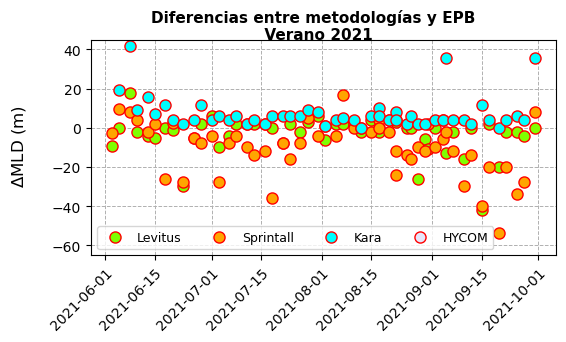

In [93]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 25,78 
    ax.plot(datos['MT'][ini:fin], datos['LEVITUS'][ini:fin]-datos['PE'][ini:fin],'o',mfc='chartreuse',mec='red',markersize=8,label='Levitus')
    ax.plot(datos['MT'][ini:fin], datos['SPRINTALL'][ini:fin]-datos['PE'][ini:fin],'o',mfc='orange',mec='red',markersize=8,label='Sprintall')
    ax.plot(datos['MT'][ini:fin], datos['KARA'][ini:fin]-datos['PE'][ini:fin],'o',mfc='cyan',mec='red',markersize=8,label='Kara')
    ax.plot(datos['MT'][ini:fin], datos['HYCOM_1'][ini:fin],'o',mfc='lavender',mec='red',markersize=8,label='HYCOM')
    ax.set_ylim(-65,45)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=9)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Verano 2021',fontsize =11,y=0.989,fontweight ='bold')

In [94]:
# data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')
data_i=pd.read_csv('C:/Users/Atmosfera/Videos/MLD_I.csv')
type(data_i), data_i

(pandas.core.frame.DataFrame,
             mt  Levitus  Sprintall    Kara   Hycom     epb  Hycom_i
 0   2013-12-01    63.63      15.89   65.55   73.65   59.59    14.06
 1   2013-12-11    69.51      19.87   71.51   68.89   65.55     3.34
 2   2013-12-21    71.54      23.84   77.42   78.88   73.49     5.39
 3   2013-12-31    89.42      29.80   91.28   89.51   85.41     4.11
 4   2014-01-10    89.42      17.92   91.36  101.77   85.41    16.36
 ..         ...      ...        ...     ...     ...     ...      ...
 70  2021-03-10   105.22      19.79  123.14     Nan  103.31      NaN
 71  2021-03-15   107.25      15.86  129.14     Nan  107.29      NaN
 72  2021-03-20   101.33      15.94  107.25     Nan   51.36      NaN
 73  2021-03-25     4.93      15.90   53.65     Nan   53.69      NaN
 74  2021-03-30    67.60      17.85   73.52     Nan   69.58      NaN
 
 [75 rows x 7 columns])

In [95]:
data_i['mt'] = pd.to_datetime(data_i['mt'])
print (type(data_i.mt[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


C:\Users\Atmosfera\AppData\Local\Temp\ipykernel_17788\3388353701.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_i['mt'] = pd.to_datetime(data_i['mt'])


In [96]:
base = data_i.sort_values(by='mt')
base

,mt,Levitus,Sprintall,Kara,Hycom,epb,Hycom_i
0,2013-12-01,63.63,15.89,65.55,73.65,59.59,14.06
1,2013-12-11,69.51,19.87,71.51,68.89,65.55,3.34
2,2013-12-21,71.54,23.84,77.42,78.88,73.49,5.39
3,2013-12-31,89.42,29.80,91.28,89.51,85.41,4.11
4,2014-01-10,89.42,17.92,91.36,101.77,85.41,16.36
...,...,...,...,...,...,...,...
72,2021-03-20,101.33,15.94,107.25,Nan,51.36,NaN
48,2021-03-22,77.44,17.88,85.43,Nan,79.47,NaN
73,2021-03-25,4.93,15.90,53.65,Nan,53.69,NaN
49,2021-03-27,8.94,15.90,73.55,Nan,11.92,NaN


In [97]:
# base['mt'][0:13], base['mt'][13:25], base['mt'][26:]

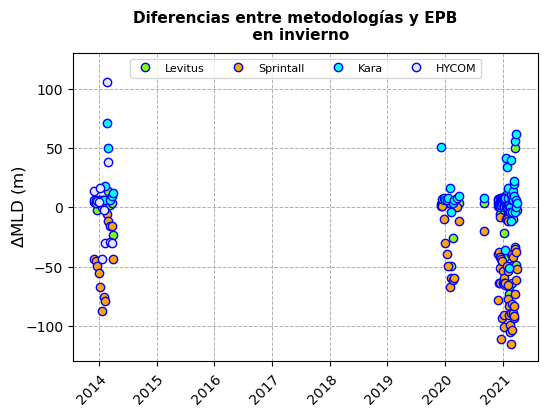

In [100]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,4))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12)#,x=-0.008)

    ax.plot(base['mt'], base['Levitus']-base['epb'],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    ax.plot(base['mt'], base['Sprintall']-base['epb'],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    ax.plot(base['mt'], base['Kara']-base['epb'],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    ax.plot(base['mt'][0:12], base['Hycom_i'][0:12],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    ax.set_ylim(-130,130)

    ax.legend(ncol=4,fontsize=8, loc = 'upper center')
    ax.grid(linestyle='--',linewidth=0.7)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n en invierno',fontsize =11,y=0.99,fontweight ='bold')


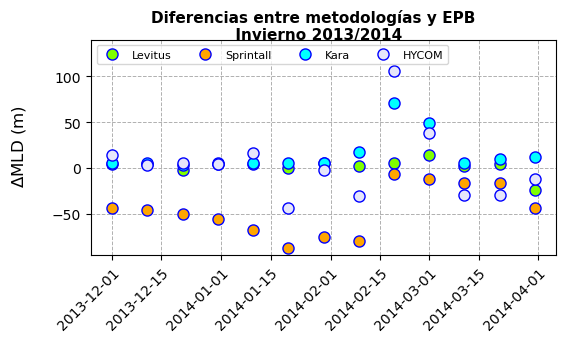

In [101]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 0,13 
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    ax.set_ylim(-95,140)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8, loc = 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2013/2014',fontsize =11,y=0.989,fontweight ='bold')

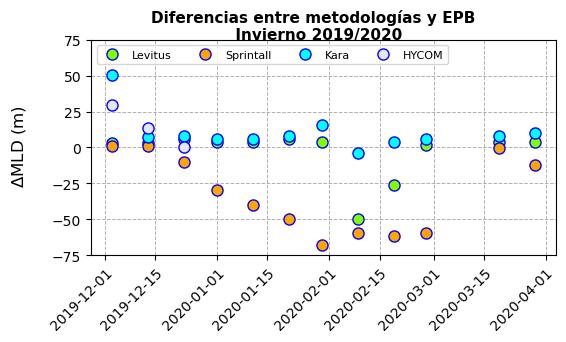

In [102]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 13,25 
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    ax.set_ylim(-75,75)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8, loc= 'upper left')
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2019/2020',fontsize =11,y=0.989,fontweight ='bold')

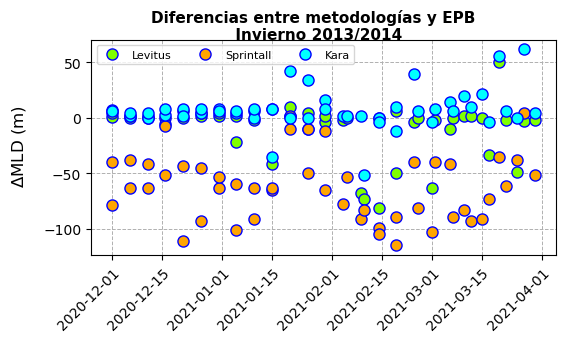

In [103]:
with sea.plotting_context():
    fig, ax = plt.subplots(figsize=(6,2.8))
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=12,x=-0.01)
    # fig.supxlabel('Tiempo ',fontsize=12)
    ini, fin = 26,78
    ax.plot(base['mt'][ini:fin], base['Levitus'][ini:fin]-base['epb'][ini:fin],'o',mfc='chartreuse',mec='blue',markersize=8,label='Levitus')
    ax.plot(base['mt'][ini:fin], base['Sprintall'][ini:fin]-base['epb'][ini:fin],'o',mfc='orange',mec='blue',markersize=8,label='Sprintall')
    ax.plot(base['mt'][ini:fin], base['Kara'][ini:fin]-base['epb'][ini:fin],'o',mfc='cyan',mec='blue',markersize=8,label='Kara')
    # ax.plot(base['mt'][ini:fin], base['Hycom_i'][ini:fin],'o',mfc='lavender',mec='blue',markersize=8,label='HYCOM')
    # ax.set_ylim(-2,70)
    # ax.invert_yaxis()
    ax.legend(ncol=4,fontsize=8)
    ax.grid(linestyle='--',linewidth=0.7)
    # ax.get_xaxis().set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.suptitle('Diferencias entre metodologías y EPB \n Invierno 2013/2014',fontsize =11,y=0.989,fontweight ='bold')

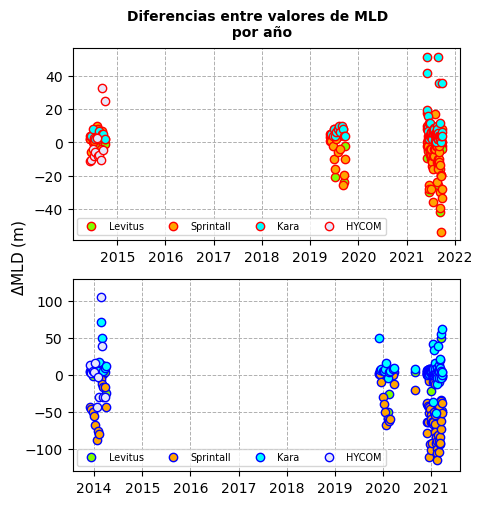

In [104]:
with sea.plotting_context():
    fig,axs = plt.subplots(2,1,figsize=(5,5.5))#,sharey=True)
    fig.suptitle('Diferencias entre valores de MLD \n por año', fontsize=10,fontweight='bold', y=0.95) #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    fig.supylabel(r'$\Delta$MLD (m)',fontsize=11, x=-0.0001)
    # fig.subplots_adjust(vspace=5)
    axs[0].plot(datos['MT'], datos['LEVITUS']-datos['PE'],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
    axs[0].plot(datos['MT'], datos['SPRINTALL']-datos['PE'],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
    axs[0].plot(datos['MT'], datos['KARA']-datos['PE'],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    axs[0].plot(datos['MT'][0:12], datos['HYCOM_1'][0:12],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')
    axs[0].legend(ncol=4,fontsize=7, loc = 'lower left')
    axs[0].grid(linestyle='--',linewidth=0.7)

    
    axs[1].plot(base['mt'], base['Levitus']-base['epb'],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    axs[1].plot(base['mt'], base['Sprintall']-base['epb'],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    axs[1].plot(base['mt'], base['Kara']-base['epb'],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    axs[1].plot(base['mt'][0:12], base['Hycom_i'][0:12],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    
    axs[1].set_ylim(-130,130)
    axs[1].legend(ncol=4,fontsize=7, loc = 'lower left')
    axs[1].grid(linestyle='--',linewidth=0.7)
plt.savefig('C:/Users/Atmosfera/Pictures/ARGO/MLD_epb.png')

In [106]:
data=pd.read_csv('C:/Users/Atmosfera/Videos/MLD.csv')

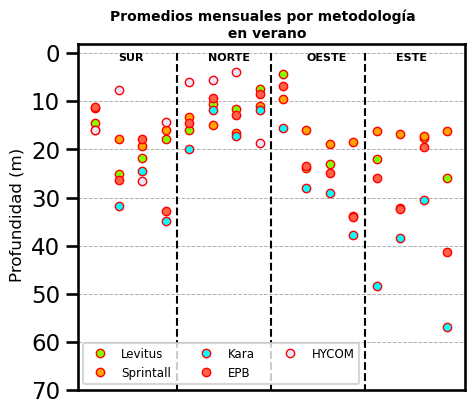

In [107]:
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(5,4.5))
    fig.supylabel('Profundidad (m)',fontsize=12,x=-0.01)

    ax.plot(data['LEVITUS'][0:16],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')
#     # ax.plot(data['LEVITUS'][16:31],'o',mfc='yellowgreen',mec='red',markerize=6)

    ax.plot(data['SPRINTALL'][0:16],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')
# #     # ax.plot(data['SPRINTALL'][16:31],'o',mfc='white',mec='red',markersize=6)

    ax.plot(data['KARA'][0:16],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
#     # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['EPB'][0:16],'o',mfc='tomato',mec='red',markersize=6,label='EPB')
#     # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['HYCOM'][0:16],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)

    # plt.plot(data[:][0:16],'.')
    ax.plot([3.5,3.5],[0,70],'k--',linewidth=1.5)
    ax.plot([7.5,7.5],[0,70],'k--',linewidth=1.5)
    ax.plot([11.5,11.5],[0,70],'k--',linewidth=1.5)
    # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
    plt.text(1,1.5,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(4.8,1.5,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(9,1.5,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(12.8,1.5,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
    ax.set_ylim(-2,70)
    ax.invert_yaxis()
    ax.legend(ncol=3,fontsize=8.5)
    ax.grid(linestyle='--',linewidth=0.7)
    ax.get_xaxis().set_visible(False)
    
    plt.suptitle('Promedios mensuales por metodología \n en verano',fontsize =10,y=0.955,fontweight ='bold')

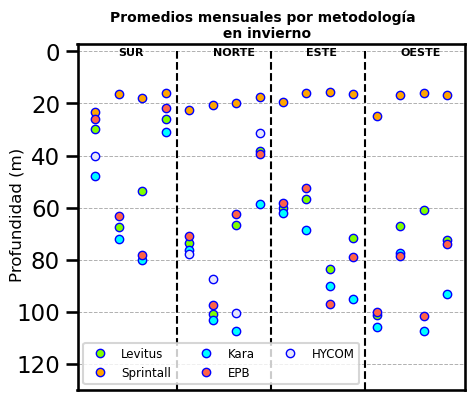

In [108]:
with sea.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(5,4.5))
    fig.supylabel('Profundidad (m)',fontsize=12,x=-0.01)

    ax.plot(data['LEVITUS'][16:32],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    # ax.plot(data['LEVITUS'][16:31],'o',mfc='yellowgreen',mec='red',markersize=6)

    ax.plot(data['SPRINTALL'][16:32],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    # ax.plot(data['SPRINTALL'][16:31],'o',mfc='white',mec='red',markersize=6)

    ax.plot(data['KARA'][16:32],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['EPB'][16:32],'o',mfc='tomato',mec='blue',markersize=6,label='EPB')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)
    
    ax.plot(data['HYCOM'][16:32],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')
    # ax.plot(data['KARA'][16:31],'o',mfc='cyan',mec='red',markersize=6)

    # plt.plot(data[:][0:16],'.')
    ax.plot([19.5,19.5],[0,130],'k--',linewidth=1.5)
    ax.plot([23.5,23.5],[0,130],'k--',linewidth=1.5)
    ax.plot([27.5,27.5],[0,130],'k--',linewidth=1.5)
    # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
    plt.text(17,1.8,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(21,1.8,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(25,1.8,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    plt.text(29,1.8,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
    ax.set_ylim(-3,130)
    ax.legend(ncol=3,loc='lower left',fontsize=8.5)
    ax.invert_yaxis()
    ax.grid(linestyle='--',linewidth=0.7)
    ax.get_xaxis().set_visible(False)
    plt.suptitle('Promedios mensuales por metodología \n en invierno',fontsize =10,y=0.955,fontweight ='bold')

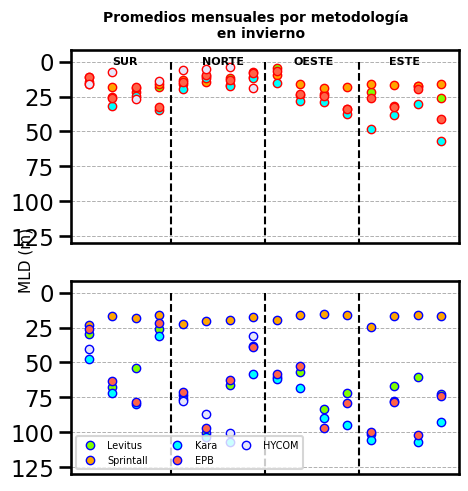

In [111]:
with sea.plotting_context('talk'):
    fig,axs = plt.subplots(2,1,figsize=(5,5.5))#,sharey=True)
    fig.suptitle('Promedios mensuales por temporada', fontsize=10,fontweight='bold') #%ds.JULD[i].dt.strftime('%y/%m/%d').values, fontsize=12)
    fig.supylabel('MLD (m)',fontsize=11)
    # fig.subplots_adjust(vspace=5)
    axs[0].plot(data['LEVITUS'][0:16],'o',mfc='chartreuse',mec='red',markersize=6,label='Levitus')

    axs[0].plot(data['SPRINTALL'][0:16],'o',mfc='orange',mec='red',markersize=6,label='Sprintall')

    axs[0].plot(data['KARA'][0:16],'o',mfc='cyan',mec='red',markersize=6,label='Kara')
    
    axs[0].plot(data['EPB'][0:16],'o',mfc='tomato',mec='red',markersize=6,label='EPB')
    
    axs[0].plot(data['HYCOM'][0:16],'o',mfc='lavender',mec='red',markersize=6,label='HYCOM')

    axs[0].plot([3.5,3.5],[0,130],'k--',linewidth=1.5)
    axs[0].plot([7.5,7.5],[0,130],'k--',linewidth=1.5)
    axs[0].plot([11.5,11.5],[0,130],'k--',linewidth=1.5)
    # ax.plot([15,16],[0,70],'k--',linewidth=1.5)
    
    axs[0].text(1,1.5,'SUR',fontsize=8,rotation=0,color='k',fontweight ='bold')
    axs[0].text(4.8,1.5,'NORTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    axs[0].text(8.7,1.5,'OESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    axs[0].text(12.8,1.5,'ESTE',fontsize=8,rotation=0,color='k',fontweight ='bold')
    
    axs[0].set_ylim(-8,130)
    axs[0].invert_yaxis()
    axs[0].grid(linestyle='--',linewidth=0.7)
    axs[0].get_xaxis().set_visible(False)

    axs[1].plot(data['LEVITUS'][16:32],'o',mfc='chartreuse',mec='blue',markersize=6,label='Levitus')
    axs[1].plot(data['SPRINTALL'][16:32],'o',mfc='orange',mec='blue',markersize=6,label='Sprintall')
    axs[1].plot(data['KARA'][16:32],'o',mfc='cyan',mec='blue',markersize=6,label='Kara')
    axs[1].plot(data['EPB'][16:32],'o',mfc='tomato',mec='blue',markersize=6,label='EPB')
    axs[1].plot(data['HYCOM'][16:32],'o',mfc='lavender',mec='blue',markersize=6,label='HYCOM')

    axs[1].plot([19.5,19.5],[0,130],'k--',linewidth=1.5)
    axs[1].plot([23.5,23.5],[0,130],'k--',linewidth=1.5)
    axs[1].plot([27.5,27.5],[0,130],'k--',linewidth=1.5)
    axs[1].set_ylim(-8,130)
    axs[1].legend(ncol=3,loc='lower left',fontsize=7)
    axs[1].invert_yaxis()
    axs[1].grid(linestyle='--',linewidth=0.7)#,y=2)
    axs[1].get_xaxis().set_visible(False)
    plt.suptitle('Promedios mensuales por metodología \n en invierno',fontsize =10,y=0.955,fontweight ='bold')
